# Определение возраста покупателей

## Цель исследования:
Постройте модель, которая по фотографии определит приблизительный возраст человека. 

## Ход исследования:
1. Провести исследовательский анализ набора фотографий._Будет включать в себя:_ 
_- анализ объема данных,_
_- анализ изображений и их качества,_
_- анализ распределения количества фотографий относительно возраста изображенных людей._
2. Подготовить данные к обучению. _Предстоит решить задачу регрессии для определения возраста человека. В качестве класса модели машинного обучения была выбрана нейронная сеть со свёрточными слоями - ResNet50. В качестве метрики была использована MAE._
3. Обучить нейроную сеть и оценить ее качества. _Оценка качества модели будет произведена на основании сравнения значения метрики MAE на тестовой выборке с установленным пороговым значением._ 

## Описание данных:
Набор фотографий людей с указанием возраста.

Примечание:

Значение метрики MAE модели должны получить не больше 8.

## Исследовательский анализ данных

Подготовка рабочей среды.

In [1]:
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
plt.style.use('dark_background')

Загрузим и рассмотрим данные.

In [2]:

labels = pd.read_csv('/datasets/faces/labels.csv')
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345)

Found 7591 validated image filenames.


In [3]:
nRow, nCol = labels.shape
print(f'Данные содержат {nRow} строки и {nCol} столбца.')

Данные содержат 7591 строки и 2 столбца.


In [4]:
labels

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17
...,...,...
7586,007608.jpg,14
7587,007609.jpg,37
7588,007610.jpg,28
7589,007611.jpg,20


In [5]:
labels.info

<bound method DataFrame.info of        file_name  real_age
0     000000.jpg         4
1     000001.jpg        18
2     000002.jpg        80
3     000003.jpg        50
4     000004.jpg        17
...          ...       ...
7586  007608.jpg        14
7587  007609.jpg        37
7588  007610.jpg        28
7589  007611.jpg        20
7590  007612.jpg        47

[7591 rows x 2 columns]>

In [6]:
labels.describe()

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


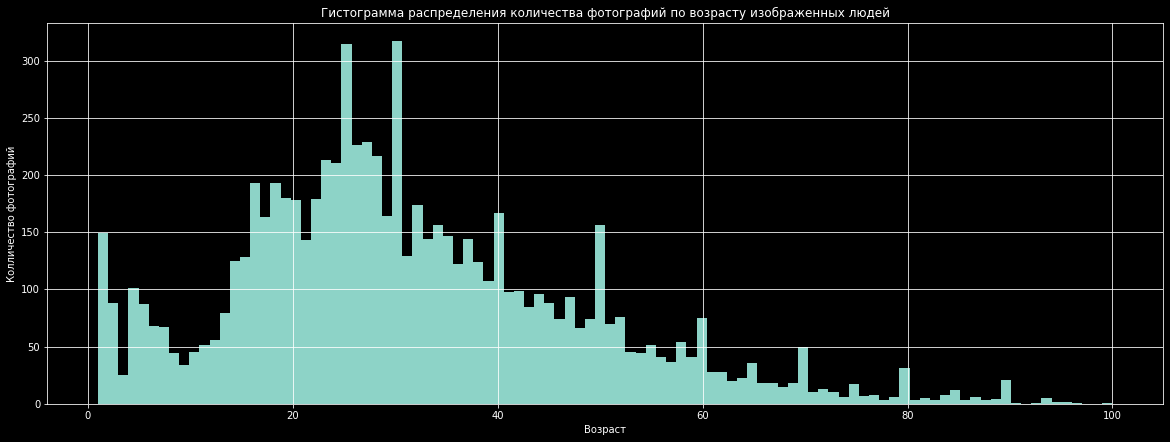

In [7]:
labels.hist(bins=100, figsize=(20,7))
plt.title("Гистограмма распределения количества фотографий по возрасту изображенных людей")
plt.xlabel("Возраст")
plt.ylabel("Колличество фотографий")
plt.show()


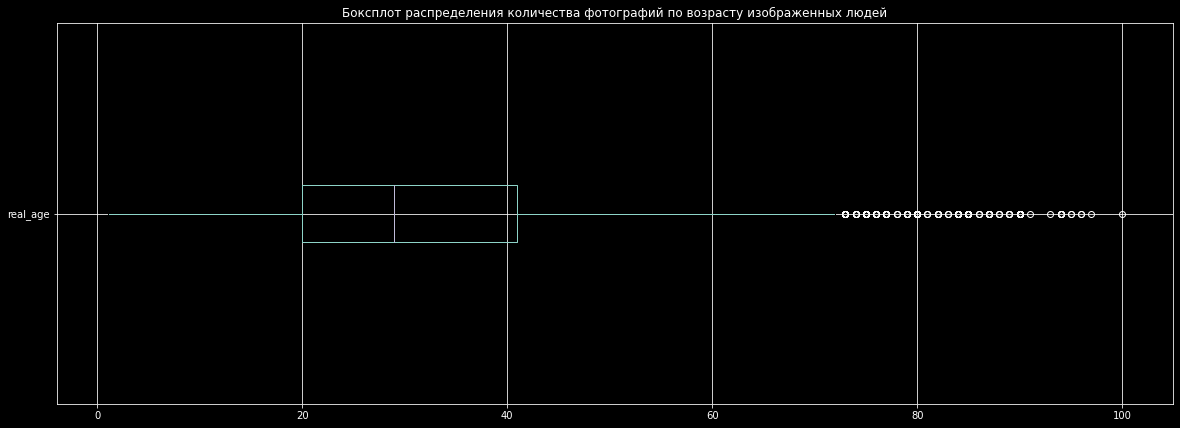

In [8]:
labels.boxplot(vert=False, figsize=(20,7))
plt.title("Боксплот распределения количества фотографий по возрасту изображенных людей")
plt.show()

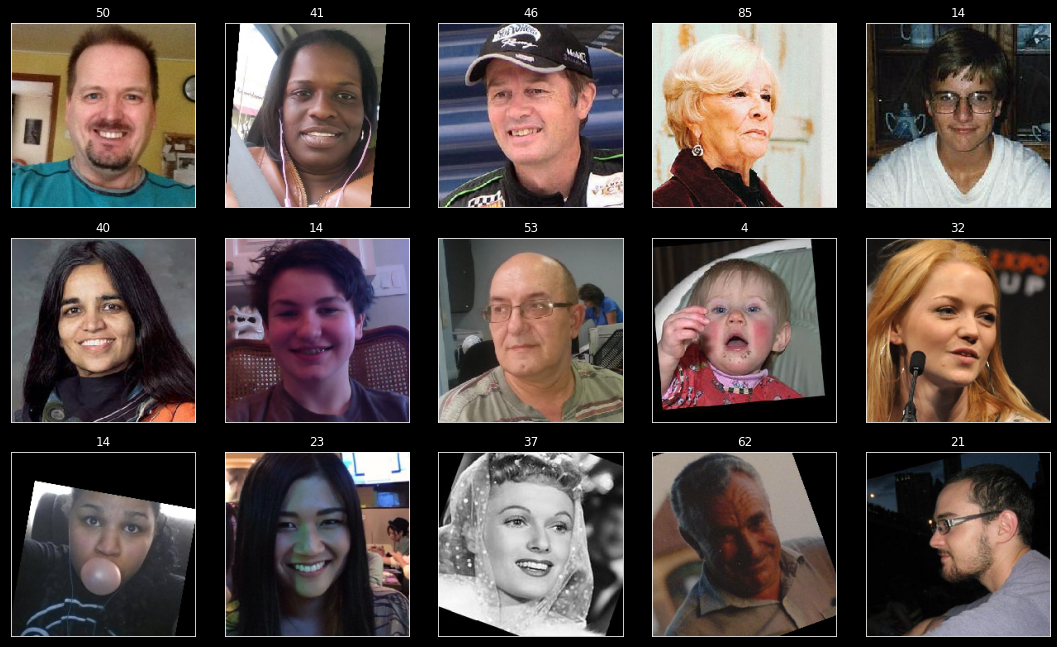

In [9]:
X,Y = next(train_gen_flow)

fig = plt.figure(figsize=(15,15))
for i in range(15):
    fig.add_subplot(5, 5, i+1)
    plt.title(Y[i])
    plt.xticks([])
    plt.yticks([])
    plt.imshow(X[i])
    plt.tight_layout()

### Выводы по итогу исследовательского анализа
Мы имеем дело с набором данных, который содержит 7591 наблюдения и 2 признака(номер изображения и возраст человека). Размер изображений 224 на 224 пикселей. Формат  - jpg.

Набор данных состоит из изображения лица человека, фигуры человека. Чаще всего изображение представляет собой цветной портрет человека расположенный в центре, площадь изображения области лица занимает около 30% площади изображения. При этом встречаются изображения:
- монохромные, 
- повернутые,
- сжатые и растянутые,
- изображения содержащие группы людей(2 и более),
- лица людей отображены в различных ракурсах и с разными выражениями лиц,
- изображения различных расс людей, 
- разный фон у изображений,
- могут содержать головные уборы, очки(в том числе и солнечные)и иные предметы,
- могут содержать изображение человека в полный рост,
- различная четкость изображений и освещенность лиц.

Анализ распределения количества фотографий относительно возраста изображенных людей показал:
- количество изображений, соответствующих каждому возрасту, распределены не равномерно. Самое большое количество фотографий соответствуют возрасту 30-35 лет, меньше всего изображений людей от 75 лет и старше,отсутствуют фото детей от 0 до года.
- максимальный представленный возраст - 100 лет,  минимальный - 1 год.
- на гистограмме мы видим, что изображений, кратным 10 годам больше, чем промежуточным возрастам в каждом десятилетнем отрезке.

Можно предположить, что модель сможет:
- хорошо обучиться на изображениях, соответствующих возрасту 20-41 года. 
- плохо идентифицировать возраст 75+.
- могут быть ошибки в идентификации возраста до 18 лет.

Какие шаги могут быть предприняты для подготовки данных:
- сделать изображения монохромными.
- выделить центральные части изображений, на которых изображаются лицо и шея до линии плеч.
- добавить повернутые, отзеркаленые изображения тех категорий возраста, которые недопредставлены в наборе данных.

## Обучение модели

import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

def load_train(path):
    labels = pd.read_csv(path + 'labels.csv')
    train_datagen = ImageDataGenerator(
        validation_split=0.25,
        horizontal_flip=True,
        rescale=1./255)
    train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='training',
        seed=12345)

    return train_gen_flow

def load_test(path):
    labels = pd.read_csv(path + 'labels.csv')
    test_datagen = ImageDataGenerator(
        validation_split=0.25,
        rescale=1./255)
    test_gen_flow = test_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='validation',
        seed=12345)

    return test_gen_flow


def create_model(input_shape):
    backbone = ResNet50(weights='imagenet',
                        input_shape=input_shape,
                        include_top=False)

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))

    optimizer = Adam(lr=0.0001)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

    return model

def train_model(model, train_data, test_data, batch_size=None, epochs=10,
                steps_per_epoch=None, validation_steps=None):

    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)

    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)

    return model

2023-03-07 17:27:59.385112: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libnvinfer.so.6
2023-03-07 17:27:59.386720: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libnvinfer_plugin.so.6
2023-03-07 17:28:00.239064: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2023-03-07 17:28:00.861642: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1555] Found device 0 with properties: 
pciBusID: 0000:8b:00.0 name: Tesla V100-SXM2-32GB computeCapability: 7.0
coreClock: 1.53GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 836.37GiB/s
2023-03-07 17:28:00.861713: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2023-03-07 17:28:00.861744: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2023-03-07 17:28:00.863535: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10
2023-03-07 17:28:00.863888: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcurand.so.10
2023-03-07 17:28:00.865782: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusolver.so.10
2023-03-07 17:28:00.866886: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusparse.so.10
2023-03-07 17:28:00.866943: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
2023-03-07 17:28:00.871328: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1697] Adding visible gpu devices: 0
Using TensorFlow backend.
Found 5694 validated image filenames.
Found 1897 validated image filenames.
2023-03-07 17:28:01.257173: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 AVX512F FMA
2023-03-07 17:28:01.266588: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2100000000 Hz
2023-03-07 17:28:01.267296: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x4c34050 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2023-03-07 17:28:01.267334: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2023-03-07 17:28:01.410648: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x4b11cb0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-03-07 17:28:01.410685: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Tesla V100-SXM2-32GB, Compute Capability 7.0
2023-03-07 17:28:01.413096: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1555] Found device 0 with properties: 
pciBusID: 0000:8b:00.0 name: Tesla V100-SXM2-32GB computeCapability: 7.0
coreClock: 1.53GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 836.37GiB/s
2023-03-07 17:28:01.413156: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2023-03-07 17:28:01.413165: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2023-03-07 17:28:01.413197: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10
2023-03-07 17:28:01.413207: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcurand.so.10
2023-03-07 17:28:01.413215: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusolver.so.10
2023-03-07 17:28:01.413224: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusparse.so.10
2023-03-07 17:28:01.413231: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
2023-03-07 17:28:01.417613: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1697] Adding visible gpu devices: 0
2023-03-07 17:28:01.417677: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2023-03-07 17:28:01.734365: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1096] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-03-07 17:28:01.734415: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1102]      0 
2023-03-07 17:28:01.734425: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1115] 0:   N 
2023-03-07 17:28:01.738879: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2023-03-07 17:28:01.738932: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1241] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 10240 MB memory) -> physical GPU (device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:8b:00.0, compute capability: 7.0)
Downloading data from https://github.com/keras-team/keras-applications/releases/download/resnet/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5

    8192/94765736 [..............................] - ETA: 13s
   81920/94765736 [..............................] - ETA: 1:04
  245760/94765736 [..............................] - ETA: 43s 
  753664/94765736 [..............................] - ETA: 20s
 2162688/94765736 [..............................] - ETA: 9s 
 4202496/94765736 [>.............................] - ETA: 7s
 6021120/94765736 [>.............................] - ETA: 6s
 8085504/94765736 [=>............................] - ETA: 5s
 8396800/94765736 [=>............................] - ETA: 6s
10756096/94765736 [==>...........................] - ETA: 5s
12591104/94765736 [==>...........................] - ETA: 5s
15343616/94765736 [===>..........................] - ETA: 4s
16785408/94765736 [====>.........................] - ETA: 4s
19865600/94765736 [=====>........................] - ETA: 4s
20127744/94765736 [=====>........................] - ETA: 4s
20979712/94765736 [=====>........................] - ETA: 4s
22487040/94765736 [======>.......................] - ETA: 4s
24010752/94765736 [======>.......................] - ETA: 4s
25174016/94765736 [======>.......................] - ETA: 4s
26681344/94765736 [=======>......................] - ETA: 4s
28205056/94765736 [=======>......................] - ETA: 3s
29368320/94765736 [========>.....................] - ETA: 3s
30875648/94765736 [========>.....................] - ETA: 3s
32399360/94765736 [=========>....................] - ETA: 3s
33562624/94765736 [=========>....................] - ETA: 3s
35069952/94765736 [==========>...................] - ETA: 3s
36593664/94765736 [==========>...................] - ETA: 3s
37756928/94765736 [==========>...................] - ETA: 3s
39264256/94765736 [===========>..................] - ETA: 3s
40787968/94765736 [===========>..................] - ETA: 3s
41951232/94765736 [============>.................] - ETA: 3s
43458560/94765736 [============>.................] - ETA: 3s
44982272/94765736 [=============>................] - ETA: 3s
46145536/94765736 [=============>................] - ETA: 3s
47652864/94765736 [==============>...............] - ETA: 2s
49192960/94765736 [==============>...............] - ETA: 2s
50339840/94765736 [==============>...............] - ETA: 2s
51863552/94765736 [===============>..............] - ETA: 2s
54501376/94765736 [================>.............] - ETA: 2s
54534144/94765736 [================>.............] - ETA: 2s
56057856/94765736 [================>.............] - ETA: 2s
57597952/94765736 [=================>............] - ETA: 2s
58728448/94765736 [=================>............] - ETA: 2s
59809792/94765736 [=================>............] - ETA: 2s
60891136/94765736 [==================>...........] - ETA: 2s
61972480/94765736 [==================>...........] - ETA: 2s
62922752/94765736 [==================>...........] - ETA: 2s
64004096/94765736 [===================>..........] - ETA: 1s
65085440/94765736 [===================>..........] - ETA: 1s
66166784/94765736 [===================>..........] - ETA: 1s
67117056/94765736 [====================>.........] - ETA: 1s
68198400/94765736 [====================>.........] - ETA: 1s
69279744/94765736 [====================>.........] - ETA: 1s
70361088/94765736 [=====================>........] - ETA: 1s
71311360/94765736 [=====================>........] - ETA: 1s
72392704/94765736 [=====================>........] - ETA: 1s
73474048/94765736 [======================>.......] - ETA: 1s
74555392/94765736 [======================>.......] - ETA: 1s
75505664/94765736 [======================>.......] - ETA: 1s
76587008/94765736 [=======================>......] - ETA: 1s
77668352/94765736 [=======================>......] - ETA: 1s
78749696/94765736 [=======================>......] - ETA: 1s
79699968/94765736 [========================>.....] - ETA: 1s
80781312/94765736 [========================>.....] - ETA: 0s
81879040/94765736 [========================>.....] - ETA: 0s
82960384/94765736 [=========================>....] - ETA: 0s
83894272/94765736 [=========================>....] - ETA: 0s
84975616/94765736 [=========================>....] - ETA: 0s
86089728/94765736 [==========================>...] - ETA: 0s
87187456/94765736 [==========================>...] - ETA: 0s
88088576/94765736 [==========================>...] - ETA: 0s
89186304/94765736 [===========================>..] - ETA: 0s
90300416/94765736 [===========================>..] - ETA: 0s
91414528/94765736 [===========================>..] - ETA: 0s
92282880/94765736 [============================>.] - ETA: 0s
93396992/94765736 [============================>.] - ETA: 0s
94527488/94765736 [============================>.] - ETA: 0s
94773248/94765736 [==============================] - 7s 0us/step
<class 'tensorflow.python.keras.engine.sequential.Sequential'>
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
Train for 356 steps, validate for 119 steps
Epoch 1/10
2023-03-07 17:28:19.589333: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2023-03-07 17:28:19.913379: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
356/356 - 66s - loss: 201.6614 - mae: 10.2614 - val_loss: 865.0058 - val_mae: 24.5118
Epoch 2/10
356/356 - 39s - loss: 85.1137 - mae: 6.9567 - val_loss: 129.6964 - val_mae: 8.5350
Epoch 3/10
356/356 - 38s - loss: 61.3105 - mae: 5.9302 - val_loss: 77.8245 - val_mae: 6.5892
Epoch 4/10
356/356 - 39s - loss: 41.7080 - mae: 4.9493 - val_loss: 84.4650 - val_mae: 7.0520
Epoch 5/10
356/356 - 39s - loss: 32.7852 - mae: 4.3629 - val_loss: 70.7929 - val_mae: 6.2288
Epoch 6/10
356/356 - 39s - loss: 25.7850 - mae: 3.8783 - val_loss: 72.3876 - val_mae: 6.3284
Epoch 7/10
356/356 - 38s - loss: 19.5786 - mae: 3.4200 - val_loss: 70.1539 - val_mae: 6.0963
Epoch 8/10
356/356 - 39s - loss: 16.6597 - mae: 3.1203 - val_loss: 65.3664 - val_mae: 6.0744
Epoch 9/10
356/356 - 39s - loss: 14.0015 - mae: 2.8370 - val_loss: 66.9672 - val_mae: 6.2002
Epoch 10/10
356/356 - 39s - loss: 13.1158 - mae: 2.7564 - val_loss: 68.4624 - val_mae: 6.1233
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
119/119 - 9s - loss: 68.4624 - mae: 6.1233
Test MAE: 6.1233

###  Выводы по итогу обучения модели

Удалось достигнуть значения метрики MAE больше 8. Получено значение 6.1233 на тестовой выборке.

## Анализ обученной модели

Для обучения модели мы использовали набор данных, который содержал 7591 наблюдения и 2 признака(номер изображения и возраст человека). Размер изображений 224 на 224 пикселей. Формат  - jpg.

Набор данных содержал изображения: лица человека, фигуры человека. Чаще всего изображение представляли собой цветной портрет человека расположенный в центре, площадь изображения области лица занимала около 30% площади изображения. При этом встречались изображения:
- монохромные, 
- повернутые,
- сжатые и растянутые,
- изображения содержащие группы людей(2 и более),
- лица людей отображены в различных ракурсах и с разными выражениями лиц,
- изображения различных расс людей, 
- разный фон у изображений,
- могли содержать головные уборы, очки(в том числе и солнечные)и иные предметы,
- могли содержать изображение человека в полный рост,
- различная четкость изображений и освещенность лиц.

Анализ распределения количества фотографий относительно возраста изображенных людей показал:
- количество изображений, соответствующих каждому возрасту, распределены не равномерно. Самое большое количество фотографий соответствуют возрасту 30-35 лет, меньше всего изображений людей от 75 лет и старше,отсутствуют фото детей от 0 до года.
- максимальный представленный возраст - 100 лет,  минимальный - 1 год.
- на гистограмме мы увидели, что изображений, кратным 10 годам больше, чем промежуточным возрастам в каждом десятилетнем отрезке.

В результате обучени модели нам удалось достигнуть поставленной цели:  по фотографии определять приблизительный возраст человека. Получено значение метрики MAE - 6.1233 на тестовой выборке, что удовлетворяет условию поставленной задачи.